In [1]:
import numpy as np
import pickle
import lzma
import matplotlib.pyplot as plt

Loading the record file

In [2]:
# with lzma.open("../record_1.npz", "rb") as file:
#     data = pickle.load(file)
#
# print(f"Total snapshots recorded: {len(data)}")
# print(f"Type of data: {type(data)}")
# print(f"Type of one snapshot: {type(data[0])}")

Multiple data files loading

In [3]:
import glob

# Find all record files
record_files = sorted(glob.glob("../record_*.npz"))
print(f"Found {len(record_files)} record files: {record_files}")

# Load and combine all data
data = []
for file_path in record_files:
    with lzma.open(file_path, "rb") as file:
        file_data = pickle.load(file)
        data.extend(file_data)
        print(f"Loaded {file_path}: {len(file_data)} snapshots")

print(f"\nTotal combined snapshots: {len(data)}")
print(f"Type of data: {type(data)}")
print(f"Type of one snapshot: {type(data[0])}")

Found 8 record files: ['../record_0.npz', '../record_1.npz', '../record_2.npz', '../record_3.npz', '../record_4.npz', '../record_5.npz', '../record_6.npz', '../record_7.npz']
package_folder: /home/teclis/Projects/ML_Challenge/RallyRobotPilot_2025/.venv/lib/python3.13/site-packages/ursina
asset_folder: /home/teclis/Projects/ML_Challenge/RallyRobotPilot_2025/.venv/lib/python3.13/site-packages


which: no blender in (/home/teclis/Projects/ML_Challenge/RallyRobotPilot_2025/.venv/bin:/home/teclis/.cargo/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/opt/cuda/bin:/opt/cuda/nsight_compute:/opt/cuda/nsight_systems/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/home/teclis/.local/share/JetBrains/Toolbox/scripts:/home/teclis/.lmstudio/bin)


Loaded ../record_0.npz: 2194 snapshots
Loaded ../record_1.npz: 136 snapshots
Loaded ../record_2.npz: 85 snapshots
Loaded ../record_3.npz: 120 snapshots
Loaded ../record_4.npz: 53 snapshots
Loaded ../record_5.npz: 235 snapshots
Loaded ../record_6.npz: 33 snapshots
Loaded ../record_7.npz: 179 snapshots

Total combined snapshots: 3035
Type of data: <class 'list'>
Type of one snapshot: <class 'rallyrobopilot.sensing_message.SensingSnapshot'>


Displaying first element

In [4]:
snapshot = data[0]
print("=== First Snapshot ===")
print(f"Raycast distances: {snapshot.raycast_distances}")
print(f"Car speed: {snapshot.car_speed}")
print(f"Car angle: {snapshot.car_angle}")
print(f"Car position: {snapshot.car_position}")
print(f"Current controls: {snapshot.current_controls}")
print(f"Image shape: {snapshot.image.shape if snapshot.image is not None else 'No image'}")

=== First Snapshot ===
Raycast distances: (11.98755168914795, 12.27003002166748, 13.25473403930664, 15.256402015686035, 19.115863800048828, 27.45615005493164, 53.5294303894043, 100.0, 53.52562713623047, 27.44791603088379, 4.218806266784668, 3.992945671081543, 13.185701370239258, 12.165082931518555, 11.837691307067871)
Car speed: 0.0
Car angle: -90.0
Car position: (0.0, 1.0, 0.0)
Current controls: (0, 0, 0, 0)
Image shape: No image


Converting to usable data

In [5]:
raycasts = np.array([s.raycast_distances for s in data])
speeds = np.array([s.car_speed for s in data])
controls = np.array([s.current_controls for s in data])

print(f"Raycasts shape: {raycasts.shape}")
print(f"Speeds shape: {speeds.shape}")
print(f"Controls shape: {controls.shape}")

Raycasts shape: (3035, 15)
Speeds shape: (3035,)
Controls shape: (3035, 4)


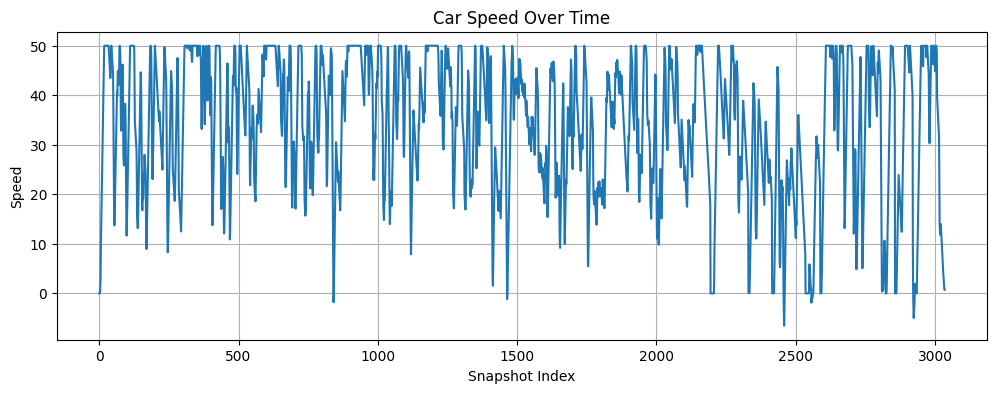

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(speeds)
plt.xlabel('Snapshot Index')
plt.ylabel('Speed')
plt.title('Car Speed Over Time')
plt.grid(True)
plt.show()

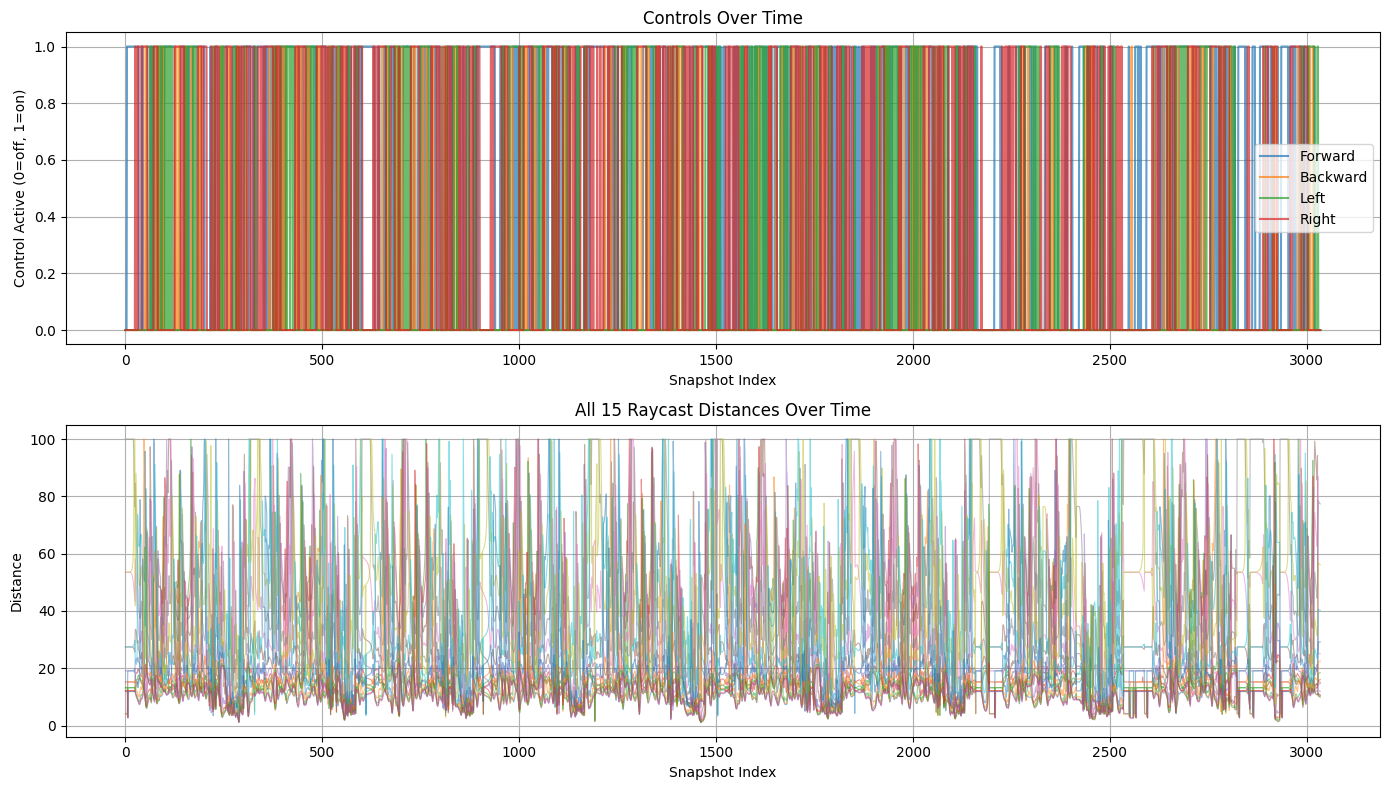

In [7]:
# Cell 6: Plot controls over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot controls (binary on/off)
ax1.plot(controls[:, 0], label='Forward', alpha=0.7)
ax1.plot(controls[:, 1], label='Backward', alpha=0.7)
ax1.plot(controls[:, 2], label='Left', alpha=0.7)
ax1.plot(controls[:, 3], label='Right', alpha=0.7)
ax1.set_xlabel('Snapshot Index')
ax1.set_ylabel('Control Active (0=off, 1=on)')
ax1.set_title('Controls Over Time')
ax1.legend()
ax1.grid(True)

# Plot all 15 raycast distances
for i in range(15):
    ax2.plot(raycasts[:, i], alpha=0.5, linewidth=0.8)
ax2.set_xlabel('Snapshot Index')
ax2.set_ylabel('Distance')
ax2.set_title('All 15 Raycast Distances Over Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

Removing the recording start adn finish

In [8]:
def filter_data(raycasts, speeds, controls, trim_start=0, trim_end=50):
    return (
        raycasts[trim_start:-trim_end],
        speeds[trim_start:-trim_end],
        controls[trim_start:-trim_end]
    )

In [9]:
def filter_data(raycasts, speeds, controls):
    # Find snapshots where car is moving OR any control is pressed
    mask = (speeds > 0.1) | (controls.sum(axis=1) > 0)

    print(f"Original samples: {len(raycasts)}")
    print(f"Removed stationary samples: {np.sum(~mask)}")
    print(f"Remaining samples: {np.sum(mask)}")

    return (
        raycasts[mask],
        speeds[mask],
        controls[mask]
    )

Trying without filtering

In [10]:
# def filter_data(raycasts, speeds, controls, trim_start=0, trim_end=0):
#     return raycasts, speeds, controls

In [11]:
raycasts_clean, speeds_clean, controls_clean = filter_data(raycasts, speeds, controls)

print(f"Original size: {len(raycasts)}")
print(f"Filtered size: {len(raycasts_clean)}")
print(f"Removed: {len(raycasts) - len(raycasts_clean)} snapshots")

Original samples: 3035
Removed stationary samples: 70
Remaining samples: 2965
Original size: 3035
Filtered size: 2965
Removed: 70 snapshots


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Combine inputs: 15 raycasts + 1 speed = 16 features
X = np.hstack([raycasts_clean, speeds_clean.reshape(-1, 1)])
y = controls_clean

print(f"X shape: {X.shape}")  # Should be (1035, 16)
print(f"y shape: {y.shape}")  # Should be (1035, 4)

# Split into train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

X shape: (2965, 16)
y shape: (2965, 4)

Training samples: 2372
Validation samples: 593


In [13]:
class DrivingNN(nn.Module):
    def __init__(self):
        super(DrivingNN, self).__init__()
        self.layer1 = nn.Linear(16, 32)   # Input (16) -> Hidden (32)
        self.layer2 = nn.Linear(32, 4)    # Hidden (32) -> Output (4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)  # Output probabilities [0, 1]
        return x

# Create model
model = DrivingNN()
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

DrivingNN(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 676


In [14]:
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("\nTraining complete!")

Epoch [10/50], Loss: 0.9547
Epoch [20/50], Loss: 0.7045
Epoch [30/50], Loss: 0.6118
Epoch [40/50], Loss: 0.5572
Epoch [50/50], Loss: 0.5184

Training complete!


In [15]:
torch.save(model.state_dict(), 'driving_model.pth')
print("Model saved as 'driving_model.pth'")

Model saved as 'driving_model.pth'


In [16]:
print("Control distribution in training data:")
print(f"Forward pressed: {np.sum(controls_clean[:, 0])} / {len(controls_clean)} = {np.mean(controls_clean[:, 0]):.2%}")
print(f"Back pressed: {np.sum(controls_clean[:, 1])} / {len(controls_clean)} = {np.mean(controls_clean[:, 1]):.2%}")
print(f"Left pressed: {np.sum(controls_clean[:, 2])} / {len(controls_clean)} = {np.mean(controls_clean[:, 2]):.2%}")
print(f"Right pressed: {np.sum(controls_clean[:, 3])} / {len(controls_clean)} = {np.mean(controls_clean[:, 3]):.2%}")

Control distribution in training data:
Forward pressed: 1390 / 2965 = 46.88%
Back pressed: 229 / 2965 = 7.72%
Left pressed: 756 / 2965 = 25.50%
Right pressed: 1117 / 2965 = 37.67%
